<h1 style="text-align: center;">Experiment-10</h1>
<h1 style="text-align: center;">Isolated Random Forest</h1>

## **Problem Statement**
**Isolation Forest** is an unsupervised anomaly detection algorithm that efficiently identifies outliers without requiring labeled training data. Unlike traditional classification methods, Isolation Forest excels at detecting rare and unusual patterns by exploiting a fundamental characteristic of anomalies: they are few in number and significantly different from normal instances.

## **Objectives**
1. Understand the intuition and mechanism behind the Isolation Forest algorithm.
2. Apply Isolation Forest using the sklearn.ensemble.IsolationForest module.
3. Visualize outlier detection results and interpret anomaly scores.
4. Compare the Isolation Forest with other anomaly detection algorithms.
5. Explore real-world use cases such as fraud detection or fault monitoring.

## **Task Outline:**

1. Load a dataset suitable for anomaly detection (e.g., credit card fraud, breast cancer, or synthetic data).
2. Preprocess the dataset: normalization, feature selection, etc.
3. Apply Isolation Forest to detect anomalies and interpret the output.
4. Visualize the results using 2D or 3D scatter plots.
5. Compare with Local Outlier Factor (LOF) or One-Class SVM (optional).
6. Explore how parameters like n_estimators and contamination affect performance.

## **Understanding Isolation Forest for Anomaly Detection**
Isolation Forest is a powerful ensemble learning technique specifically designed for anomaly detection. Unlike Random Forest, which is a supervised learning method, Isolation Forest excels at unsupervised anomaly detection by explicitly isolating outliers. Here's a concise explanation of how it works:

### **Isolation Forest Core Concept**

Isolation Forest builds on a simple but powerful principle: anomalies are easier to isolate than normal data points. The algorithm exploits this property by:

- **Random Partitioning:** Recursively partitioning the data space with random splits
- **Isolation Mechanism:** Anomalies require fewer partitions to be isolated than normal points
- **Anomaly Score:** Points with shorter average path lengths in the forest are more likely to be anomalies

### **How Isolation Forest Works**

- **Tree Building:** Multiple isolation trees are constructed by:

    - Randomly selecting a feature
    - Randomly selecting a split value between min and max values of the selected feature
    - Recursively splitting data until instances are isolated <br><br>

- **Anomaly Scoring:**
    - Anomalies are points that have short path lengths (require fewer splits to isolate)
    - Normal points typically require more splits to be isolated <br><br>

- **Ensemble Approach:**
    - The final anomaly score is the average path length across all trees
    - Lower scores indicate higher likelihood of being an anomaly

Let's implement this using Python and scikit-learn.

## **Implementation with Python**

### **Dataset description**

The **Credit Card Fraud Detection** dataset from Kaggle is a widely used resource for developing and evaluating anomaly detection algorithms in financial transaction systems.

**Dataset Details:**
**Type:** Tabular dataset (numeric transactions data)

**Features:** 31 columns:

- **Time:** Seconds elapsed between this transaction and the first transaction in the dataset
- **Amount:** Transaction amount
- **V1-V28:** Principal components obtained with PCA transformation (anonymized features)
- **Class:** Target variable (1 for fraudulent transactions, 0 for legitimate)

**Class Distribution:**

- **Legitimate transactions:** 284,315 samples (99.83%)
- **Fraudulent transactions:** 492 samples (0.17%)

**Total Samples:** 284,807 transactions

**Format:** Each record represents a credit card transaction with anonymized features due to confidentiality requirements

**Time Period:** Transactions collected during two days in September 2013

**Characteristics:**
- Highly imbalanced dataset (fraud is rare - only 0.17% of all transactions)
- Features are anonymized due to confidentiality constraints
- Only numerical input variables are available
- No missing values

### **Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_curve, precision_recall_curve, auc)
from sklearn.decomposition import PCA
import time
from matplotlib.colors import ListedColormap
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

### **Loading, exploring and preprocessing dataset (Credit Card)**

In [4]:
# Load the credit card dataset
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Display basic information about the dataset
print("\nDataset Information:")
print(f"Shape: {df.shape}")
print("\nClass distribution:")
fraud_count = df['Class'].value_counts()
print(fraud_count)
print(f"Fraud percentage: {fraud_count[1] / len(df) * 100:.4f}%")


Dataset Information:
Shape: (284807, 31)

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud percentage: 0.1727%


In [6]:
# Check for missing values
print("\nMissing values:", df.isnull().sum().sum())


Missing values: 0


In [7]:
# Explore transaction amounts
print("\nTransaction amount statistics:")
print(df['Amount'].describe())


Transaction amount statistics:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


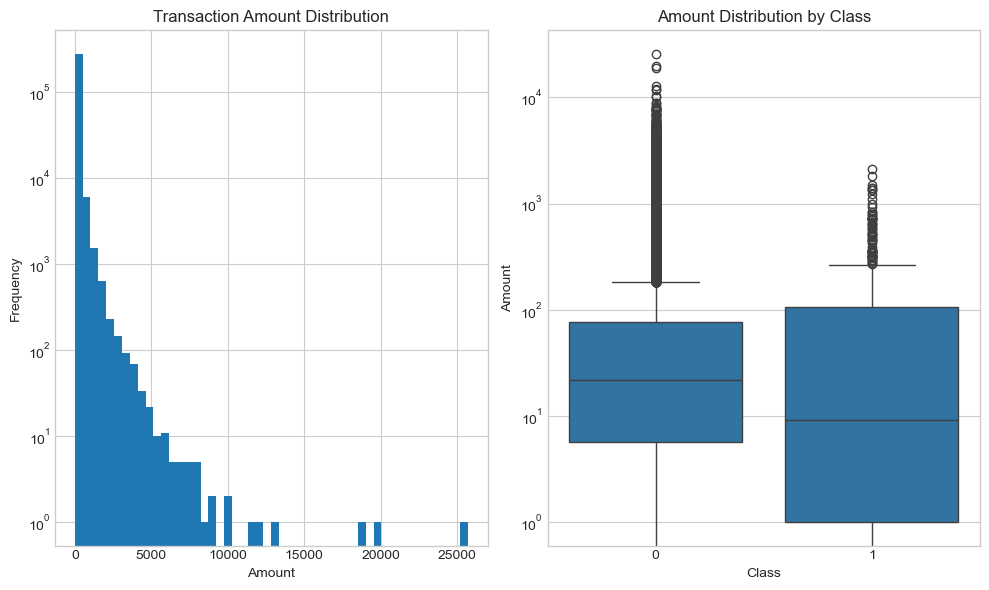

In [8]:
# Plot transaction amount distribution
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.hist(df['Amount'], bins=50)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale for better visibility

plt.subplot(122)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Amount Distribution by Class')
plt.yscale('log')  # Log scale for better visibility
plt.tight_layout()
plt.show()

In [9]:
# Data Preprocessing
X = df.drop('Class', axis=1)
y = df['Class']

In [10]:
# Save original Amount for later use
original_amount = X['Amount'].copy()

In [11]:
# Normalize 'Amount' and 'Time' features
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))
X['Time'] = scaler.fit_transform(X['Time'].values.reshape(-1, 1))

In [12]:
# Split the data (for evaluation purposes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples, Testing set: {X_test.shape[0]} samples")

Training set: 199364 samples, Testing set: 85443 samples


In [13]:
# Save original test amounts
test_amounts = original_amount.iloc[X_test.index].values

In [14]:
# Calculate contamination rate from the dataset
contamination = float(len(y[y == 1])) / len(y)
print(f"Contamination rate (fraud proportion): {contamination:.6f}")

Contamination rate (fraud proportion): 0.001727


### **Defining models to compare**

In [15]:
models = {
    "Isolation Forest": IsolationForest(
        n_estimators=100, 
        contamination=contamination, 
        random_state=42, 
        n_jobs=-1
    ),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20, 
        contamination=contamination, 
        n_jobs=-1
    ),
    "One-Class SVM": OneClassSVM(
        nu=contamination, 
        kernel='rbf', 
        gamma='auto'
    )
}

### **Function to evaluate models**

In [16]:
def evaluate_model(model_name, model, X_train, X_test, y_test):
    start_time = time.time()
    
    # Different handling for LOF vs other models
    if model_name == "Local Outlier Factor":
        # LOF is fit_predict in one step
        y_pred = model.fit_predict(X_test)
        # Get anomaly scores (negative values = more anomalous)
        scores = -model.negative_outlier_factor_
    else:
        # Train model
        model.fit(X_train)
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Get decision scores
        if model_name == "Isolation Forest":
            # Lower scores = more anomalous
            scores = -model.decision_function(X_test)
        else:  # One-Class SVM
            # Higher scores = more anomalous
            scores = -model.decision_function(X_test)
    
    training_time = time.time() - start_time
    
    # Convert predictions to binary classification (1: anomaly, 0: normal)
    # Note: Isolation Forest and One-Class SVM use -1 for anomalies, LOF uses -1 for anomalies
    y_pred_binary = np.where(y_pred == -1, 1, 0)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall curve and AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, scores)
    pr_auc = auc(recall_curve, precision_curve)
    
    return {
        "model_name": model_name,
        "predictions": y_pred_binary,
        "scores": scores,
        "confusion_matrix": confusion_matrix(y_test, y_pred_binary),
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_data": (fpr, tpr),
        "roc_auc": roc_auc,
        "pr_data": (recall_curve, precision_curve),
        "pr_auc": pr_auc,
        "training_time": training_time
    }

### **Training and evaluating all models**

In [17]:
results = {}
for name, model in models.items():
    results[name] = evaluate_model(name, model, X_train, X_test, y_test)
    print(f"Evaluated {name}...")

Evaluated Isolation Forest...
Evaluated Local Outlier Factor...
Evaluated One-Class SVM...


### **Performance comparison of models**

In [18]:
# Create a list to store each model's metrics as a dictionary
metrics_table = []

for name, result in results.items():
    metrics_table.append({
        "Model": name,
        "Precision": round(result['precision'], 4),
        "Recall": round(result['recall'], 4),
        "F1 Score": round(result['f1_score'], 4),
        "ROC AUC": round(result['roc_auc'], 4),
        "PR AUC": round(result['pr_auc'], 4),
        "Training Time (s)": round(result['training_time'], 2)
    })

# Convert the list of dicts into a pandas DataFrame
df_metrics = pd.DataFrame(metrics_table)

# Set the model name as the index
df_metrics.set_index("Model", inplace=True)

# Display the table
print("\nPerformance Comparison:")
df_metrics


Performance Comparison:


,Precision,Recall,F1 Score,ROC AUC,PR AUC,Training Time (s)
Model,,,,,,
Isolation Forest,0.2741,0.2500,0.2615,0.9431,0.1456,6.11
Local Outlier Factor,0.0135,0.0135,0.0135,0.5200,0.0030,84.10
One-Class SVM,0.0819,0.5135,0.1413,0.8997,0.0689,778.91


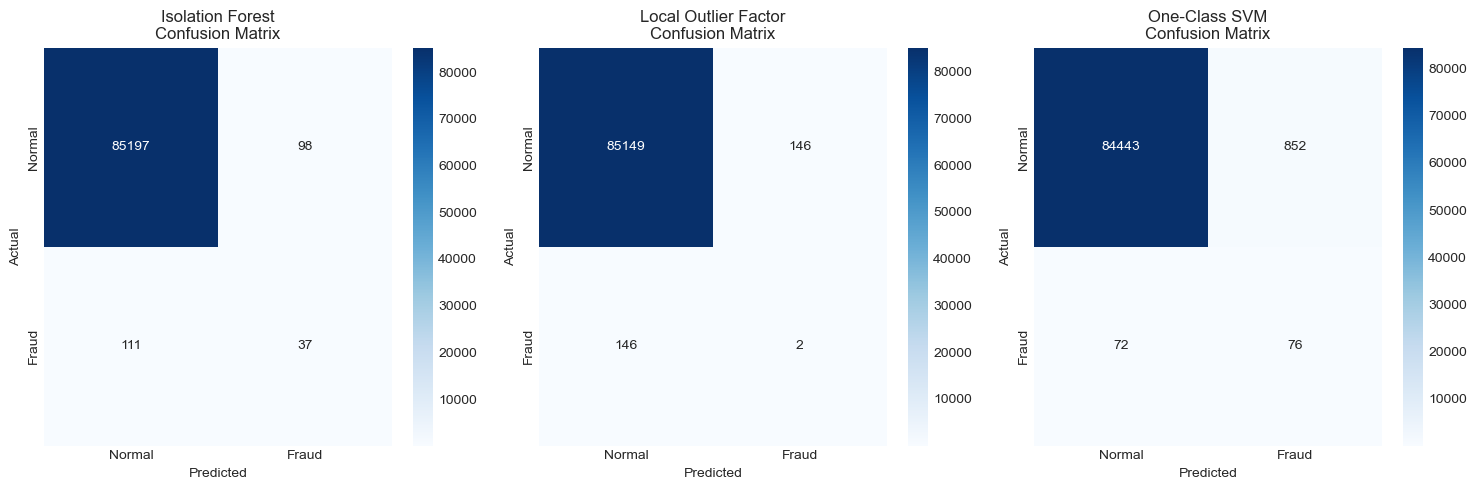

In [19]:
# Creating confusion matrix visualizations
plt.figure(figsize=(15, 5))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fraud'],
                yticklabels=['Normal', 'Fraud'])
    plt.title(f'{name}\nConfusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

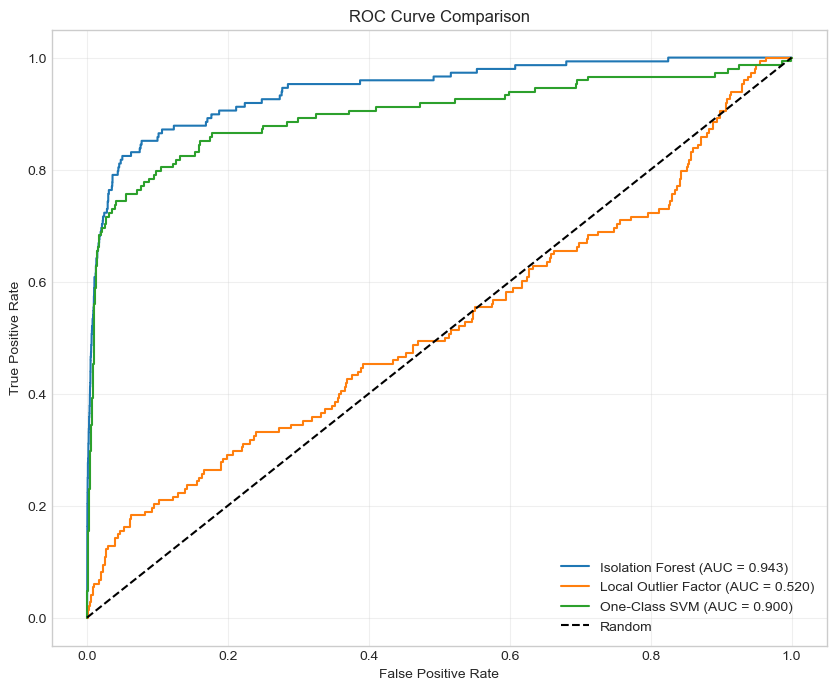

In [20]:
# Plotting ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr = result['roc_data']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

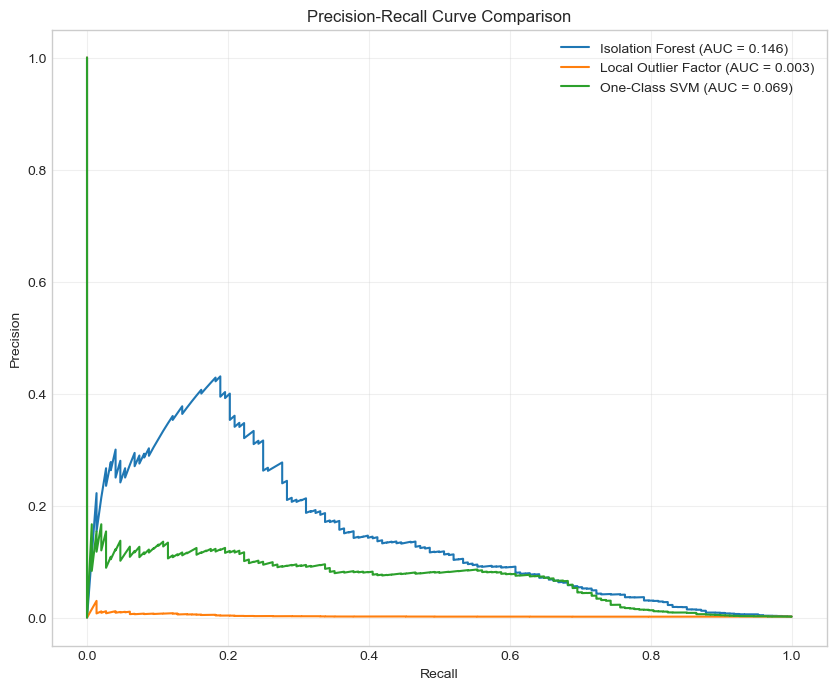

In [21]:
# Plotting Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    recall_curve, precision_curve = result['pr_data']
    plt.plot(recall_curve, precision_curve, label=f'{name} (AUC = {result["pr_auc"]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

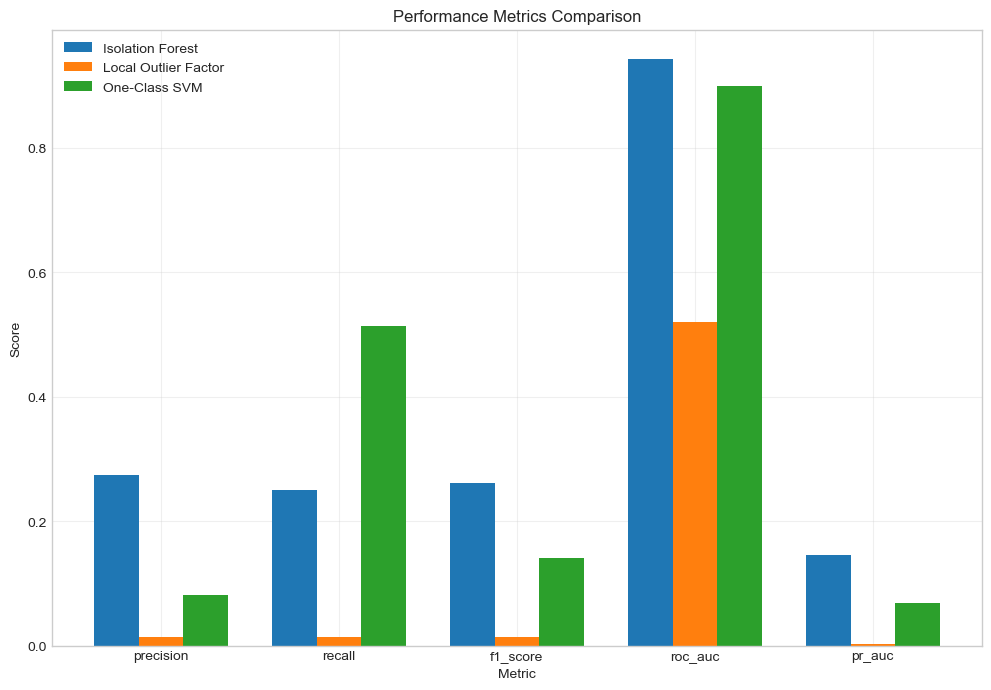

In [22]:
# Bar chart comparison of metrics
metrics = ['precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc']
metrics_data = {
    name: [result[metric] for metric in metrics]
    for name, result in results.items()
}

plt.figure(figsize=(12, 8))
x = np.arange(len(metrics))
width = 0.25
multiplier = 0

for name, values in metrics_data.items():
    offset = width * multiplier
    plt.bar(x + offset, values, width, label=name)
    multiplier += 1

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x + width, metrics)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

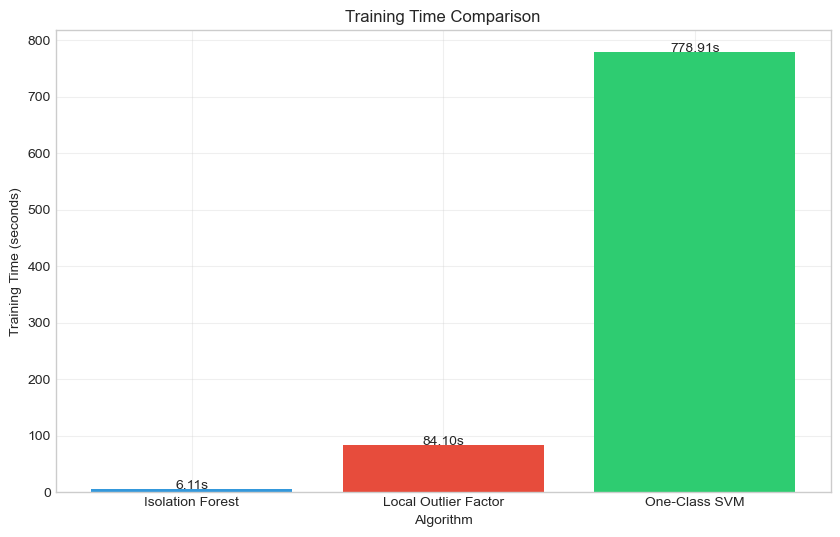

In [23]:
# Training time comparison
names = list(results.keys())
times = [results[name]['training_time'] for name in names]

plt.figure(figsize=(10, 6))
plt.bar(names, times, color=['#3498db', '#e74c3c', '#2ecc71'])
plt.xlabel('Algorithm')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
for i, time_val in enumerate(times):
    plt.text(i, time_val + 0.1, f"{time_val:.2f}s", ha='center')
plt.grid(True, alpha=0.3)
plt.show()

### **Applying PCA for visualization**


Applying PCA for visualization...
PCA explained variance ratios: [0.12860702 0.09468309 0.08035204]
Total explained variance: 0.30


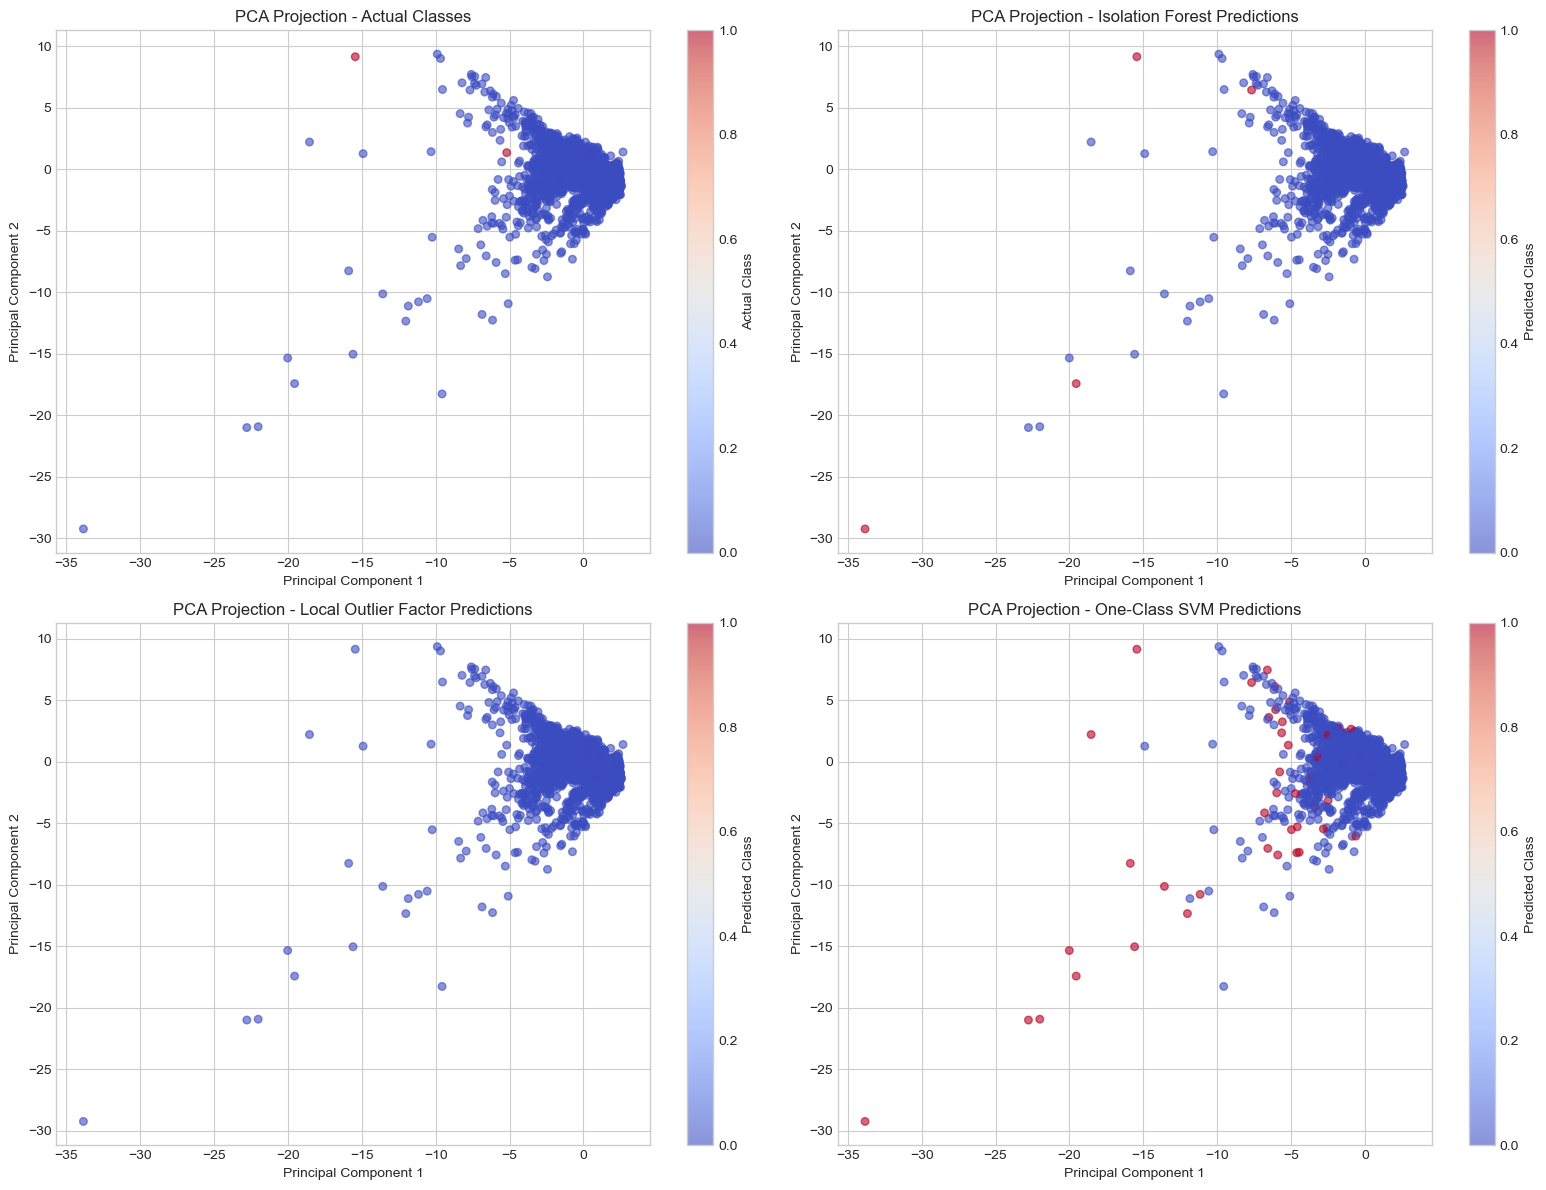

In [24]:
print("\nApplying PCA for visualization...")
# Select a subset of the data for visualization
n_samples = min(5000, X_test.shape[0])
subset_indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
X_subset = X_test.iloc[subset_indices]
y_subset = y_test.iloc[subset_indices]

# PCA transform
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_subset)

# Show PCA explained variance
explained_variance = pca.explained_variance_ratio_
print(f"PCA explained variance ratios: {explained_variance}")
print(f"Total explained variance: {sum(explained_variance):.2f}")

# Get predictions and scores for the subset
subset_results = {}
for name, result in results.items():
    subset_results[name] = {
        'predictions': result['predictions'][subset_indices],
        'scores': result['scores'][subset_indices]
    }

# 2D visualization - actual classes vs. predicted by each model
plt.figure(figsize=(16, 12))

# Plot original classes
plt.subplot(2, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_subset, cmap='coolwarm', alpha=0.6, s=30)
plt.colorbar(label='Actual Class')
plt.title('PCA Projection - Actual Classes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot model predictions
for i, (name, result) in enumerate(subset_results.items()):
    plt.subplot(2, 2, i+2)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=result['predictions'], 
                         cmap='coolwarm', 
                         alpha=0.6, 
                         s=30)
    plt.colorbar(scatter, label='Predicted Class')
    plt.title(f'PCA Projection - {name} Predictions')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

### **2D visualization - anomaly scores by each model**

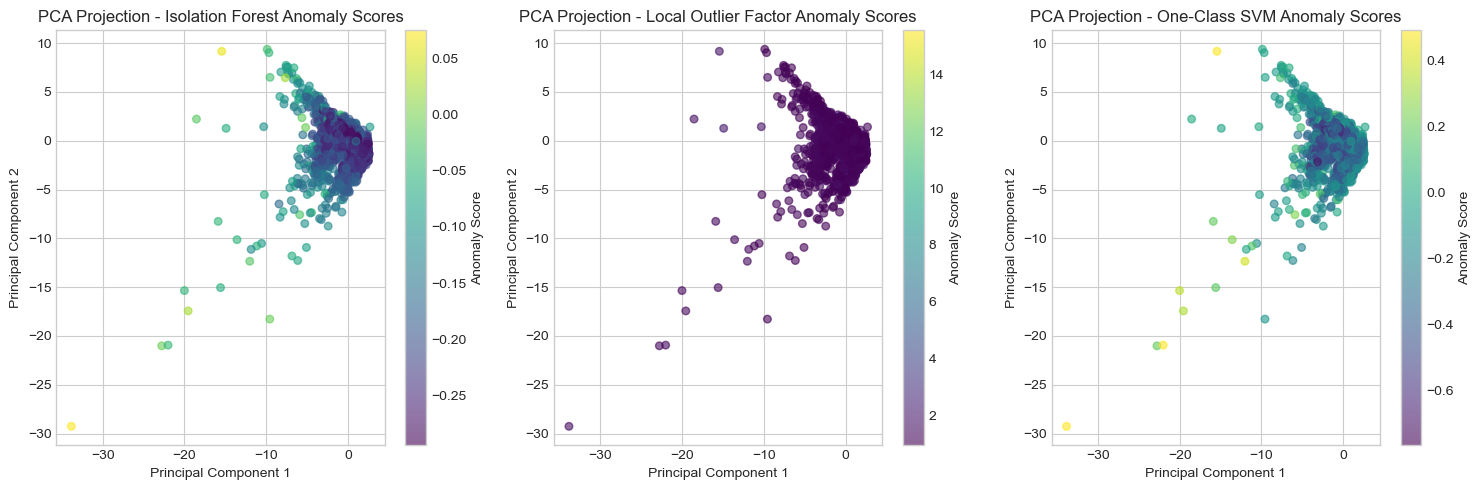

In [25]:
plt.figure(figsize=(15, 5))
for i, (name, result) in enumerate(subset_results.items()):
    plt.subplot(1, 3, i+1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=result['scores'], 
                         cmap='viridis', 
                         alpha=0.6, 
                         s=30)
    plt.colorbar(scatter, label='Anomaly Score')
    plt.title(f'PCA Projection - {name} Anomaly Scores')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

### **3D visualization - anomaly scores by each model**

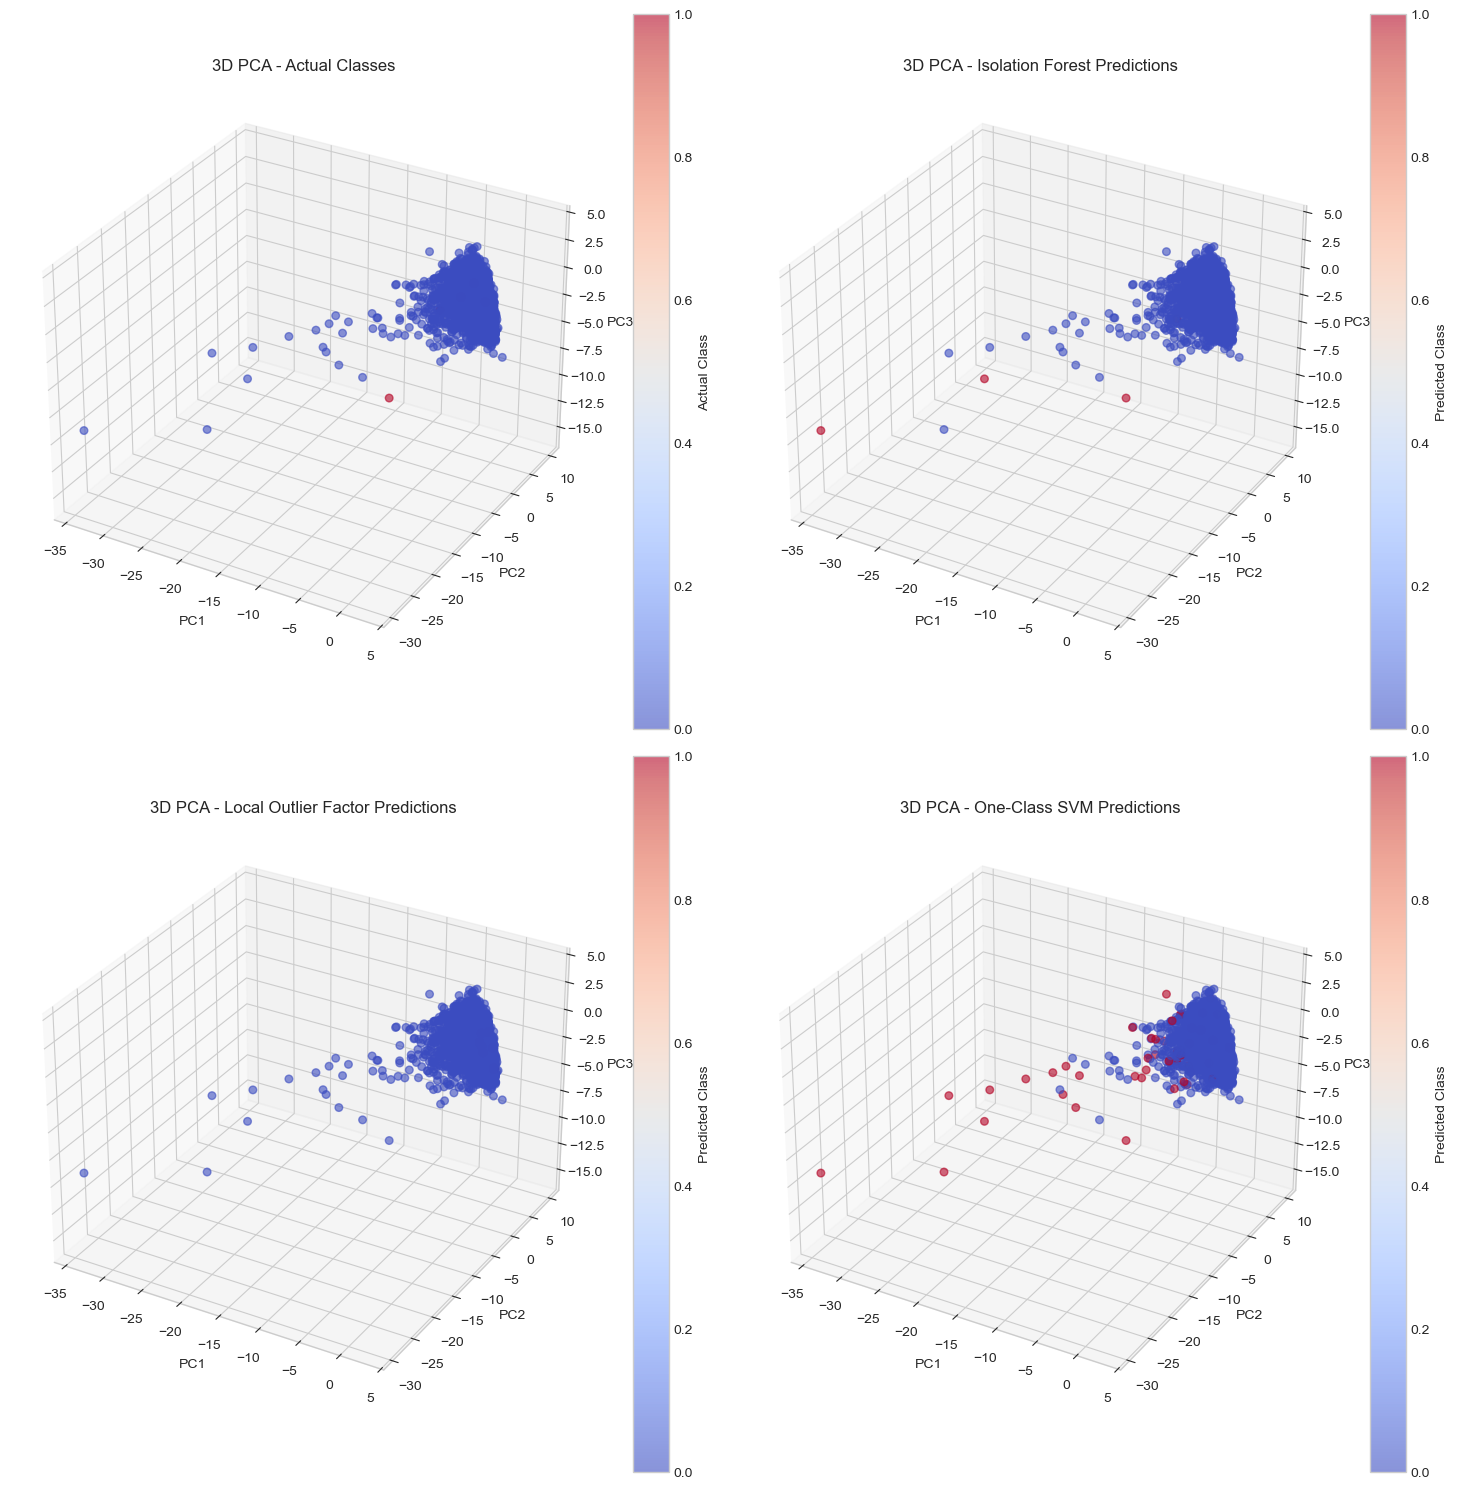

In [26]:
fig = plt.figure(figsize=(15, 15))

# Plot original classes in 3D
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                     c=y_subset, 
                     cmap='coolwarm', 
                     alpha=0.6, 
                     s=30)
plt.colorbar(scatter, ax=ax1, label='Actual Class')
ax1.set_title('3D PCA - Actual Classes')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# Plot model predictions in 3D
i = 0
for name, result in subset_results.items():
    i += 1
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                       c=result['predictions'], 
                       cmap='coolwarm', 
                       alpha=0.6, 
                       s=30)
    plt.colorbar(scatter, ax=ax, label='Predicted Class')
    ax.set_title(f'3D PCA - {name} Predictions')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

plt.tight_layout()
plt.show()

### **Error analysis visualization (misclassified points)**

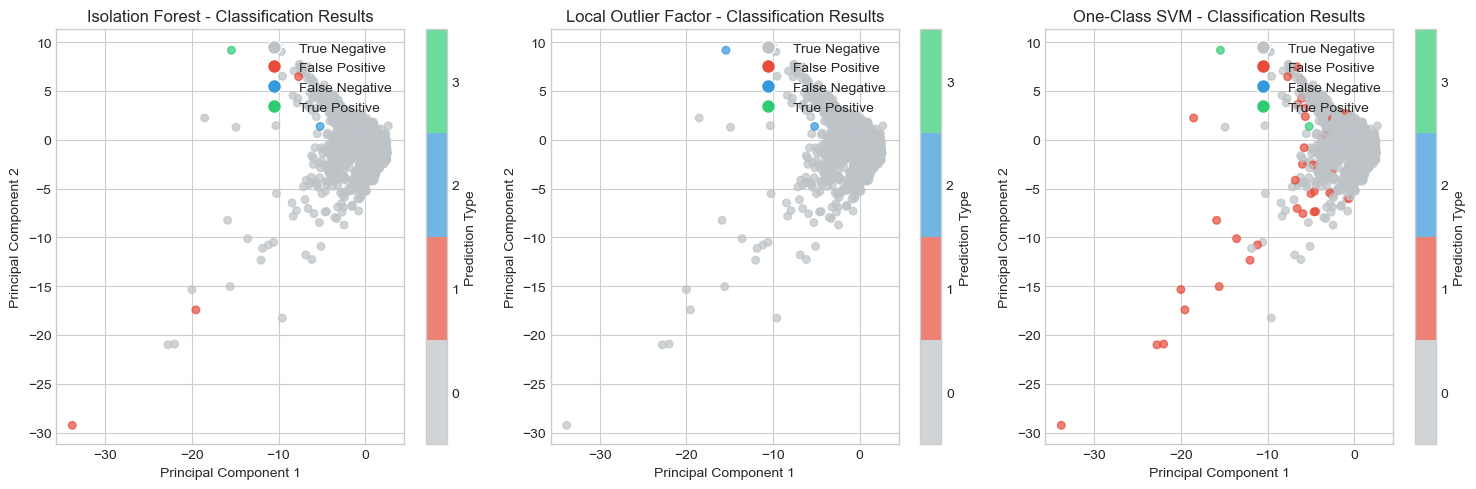

In [27]:
plt.figure(figsize=(15, 5))
for i, (name, result) in enumerate(subset_results.items()):
    plt.subplot(1, 3, i+1)
    
    # Create color map for visualization
    # 0: Correct Normal (TN), 1: False Positive (FP), 2: False Negative (FN), 3: Correct Fraud (TP)
    colors = np.zeros(len(y_subset), dtype=int)
    colors[(result['predictions'] == 0) & (y_subset == 0)] = 0  # TN
    colors[(result['predictions'] == 1) & (y_subset == 0)] = 1  # FP
    colors[(result['predictions'] == 0) & (y_subset == 1)] = 2  # FN
    colors[(result['predictions'] == 1) & (y_subset == 1)] = 3  # TP
    
    cmap = ListedColormap(['#bdc3c7', '#e74c3c', '#3498db', '#2ecc71'])
    
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap=cmap, alpha=0.7, s=30)
    plt.colorbar(scatter, ticks=[0, 1, 2, 3], 
                label='Prediction Type', 
                boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5])
    plt.clim(-0.5, 3.5)
    
    # Add legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#bdc3c7', markersize=10, label='True Negative'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=10, label='False Positive'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=10, label='False Negative'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=10, label='True Positive')
    ]
    plt.legend(handles=handles, loc='upper right')
    
    plt.title(f'{name} - Classification Results')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

In [28]:
# Convert scores and actual classes to DataFrames for easier manipulation
score_data = pd.DataFrame()

for name, result in results.items():
    # Add scores from this algorithm
    score_data[f'{name}_score'] = result['scores']

# Add actual class
score_data['actual_class'] = y_test.values
score_data['amount'] = test_amounts

### **Score Distribution Analysis with Enhanced Interpretation**

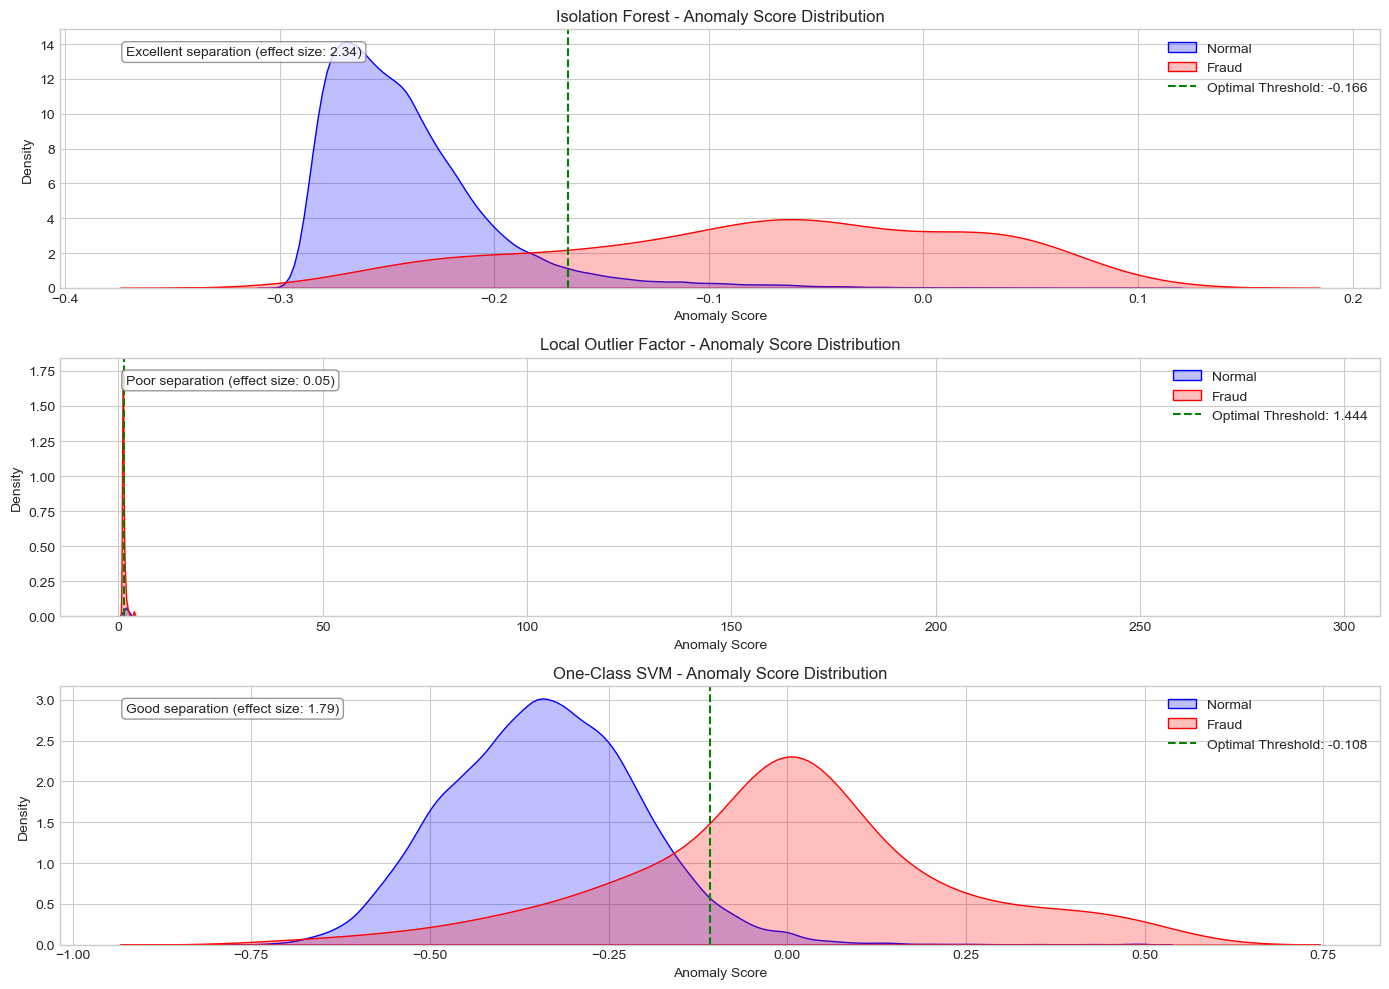

In [29]:
plt.figure(figsize=(14, 10))

# Create subplots for each algorithm
for i, name in enumerate(results.keys()):
    plt.subplot(3, 1, i+1)
    
    # Get score column
    score_col = f'{name}_score'
    
    # Plot density curves
    sns.kdeplot(score_data[score_data['actual_class'] == 0][score_col], 
                label='Normal', shade=True, color='blue')
    sns.kdeplot(score_data[score_data['actual_class'] == 1][score_col], 
                label='Fraud', shade=True, color='red')
    
    # Find optimal threshold using Youden's J statistic
    fpr, tpr, thresholds = roc_curve(score_data['actual_class'], score_data[score_col])
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]
    
    # Add vertical line for optimal threshold
    plt.axvline(x=best_threshold, color='green', linestyle='--', 
                label=f'Optimal Threshold: {best_threshold:.3f}')
    
    # Add annotation for separation quality
    # Calculate overlap between distributions
    normal_scores = score_data[score_data['actual_class'] == 0][score_col]
    fraud_scores = score_data[score_data['actual_class'] == 1][score_col]
    
    # Quantify separation (effect size)
    if len(normal_scores) > 0 and len(fraud_scores) > 0:
        effect_size = abs(normal_scores.mean() - fraud_scores.mean()) / \
                      np.sqrt((normal_scores.std()**2 + fraud_scores.std()**2) / 2)
        
        # Add text annotation about separation quality
        if effect_size < 0.5:
            separation_quality = "Poor separation"
        elif effect_size < 1.0:
            separation_quality = "Moderate separation"
        elif effect_size < 2.0:
            separation_quality = "Good separation"
        else:
            separation_quality = "Excellent separation"
            
        plt.annotate(f"{separation_quality} (effect size: {effect_size:.2f})", 
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.title(f'{name} - Anomaly Score Distribution')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

### **Score Calibration Plot**

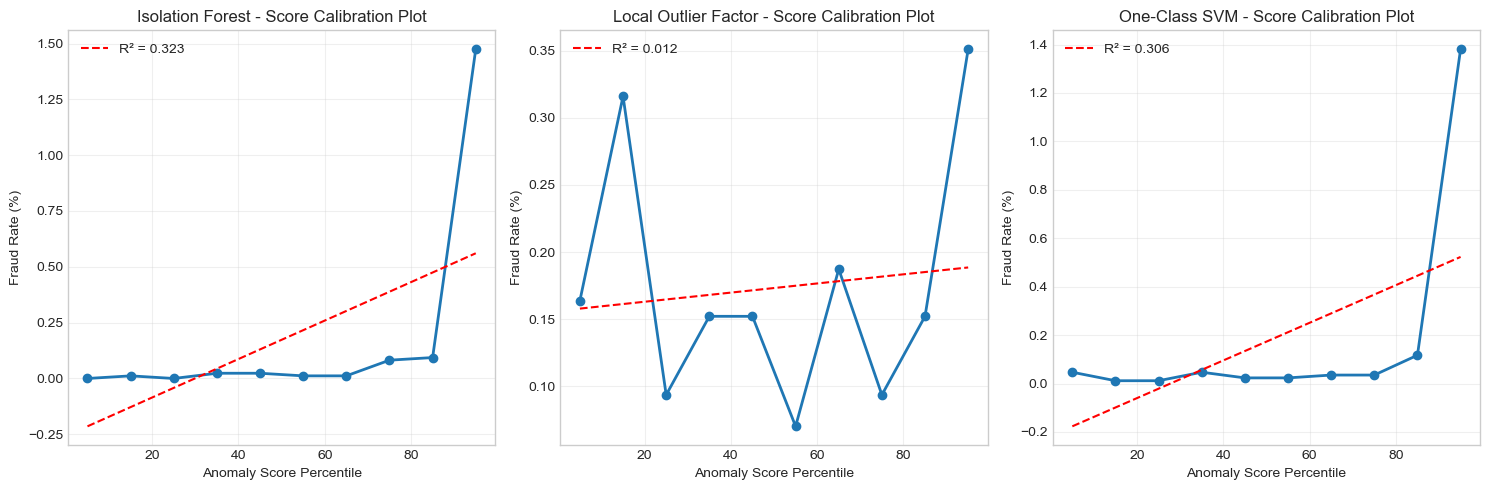

In [30]:
plt.figure(figsize=(15, 5))
for i, name in enumerate(results.keys()):
    plt.subplot(1, 3, i+1)
    
    # Get score column
    score_col = f'{name}_score'
    
    # Create percentile bins of anomaly scores
    n_bins = 10
    data = score_data.copy()
    data['score_percentile'] = pd.qcut(data[score_col], q=n_bins, labels=False)
    
    # Calculate fraud rate in each bin
    bin_fraud_rates = data.groupby('score_percentile')['actual_class'].mean()
    bin_centers = np.linspace(0, 100, n_bins, endpoint=False) + 100/(2*n_bins)
    
    # Plot fraud rate vs. score percentile
    plt.plot(bin_centers, bin_fraud_rates * 100, 'o-', linewidth=2)
    plt.xlabel('Anomaly Score Percentile')
    plt.ylabel('Fraud Rate (%)')
    plt.title(f'{name} - Score Calibration Plot')
    plt.grid(True, alpha=0.3)
    
    # Add linear fit to show calibration quality
    slope, intercept, r_value, p_value, std_err = stats.linregress(bin_centers, bin_fraud_rates * 100)
    plt.plot(bin_centers, intercept + slope * bin_centers, 'r--', 
             label=f'R² = {r_value**2:.3f}')
    plt.legend()

plt.tight_layout()
plt.show()

### **Anomaly Score vs. Transaction Amount**

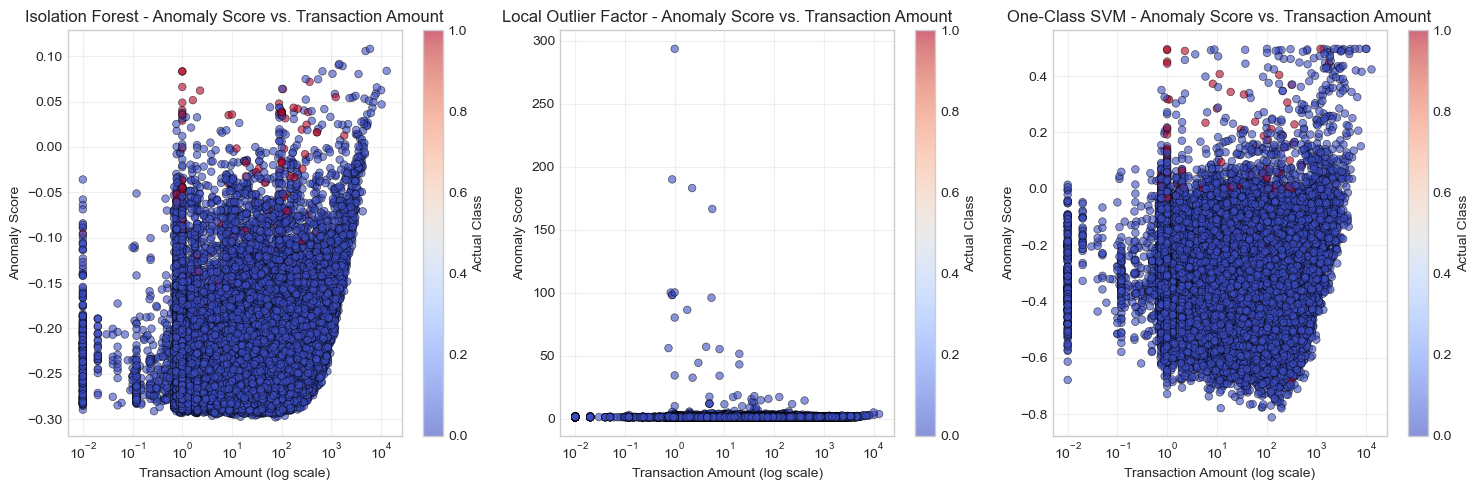

In [31]:
plt.figure(figsize=(15, 5))

for i, name in enumerate(results.keys()):
    plt.subplot(1, 3, i+1)
    
    # Get score column
    score_col = f'{name}_score'
    
    # Create scatter plot
    plt.scatter(score_data['amount'], score_data[score_col], 
                c=score_data['actual_class'], cmap='coolwarm', 
                alpha=0.6, s=30, edgecolors='k', linewidths=0.5)
    
    plt.xscale('log')  # Log scale for better visualization of amount
    plt.xlabel('Transaction Amount (log scale)')
    plt.ylabel('Anomaly Score')
    plt.title(f'{name} - Anomaly Score vs. Transaction Amount')
    plt.colorbar(label='Actual Class')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Score Ranking Visualization (Top N anomalies)**

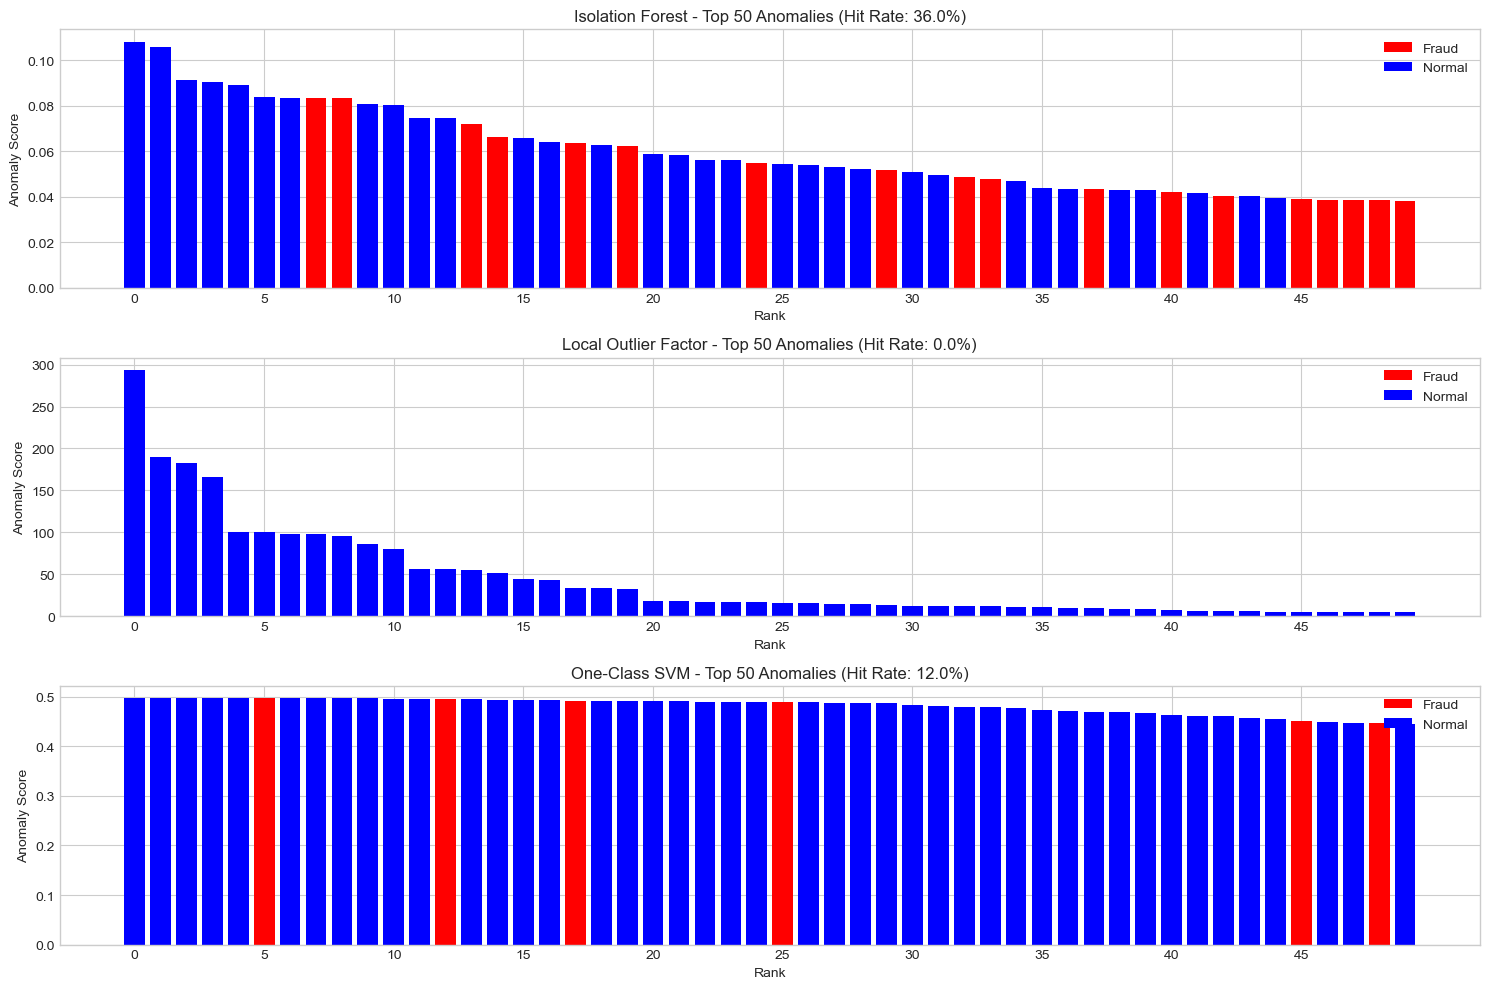

In [32]:
top_n = 50  # Number of top anomalies to examine

plt.figure(figsize=(15, 10))
for i, name in enumerate(results.keys()):
    plt.subplot(3, 1, i+1)
    
    # Get score column
    score_col = f'{name}_score'
    
    # Sort by anomaly score
    sorted_data = score_data.sort_values(by=score_col, ascending=False).reset_index(drop=True)
    top_anomalies = sorted_data.head(top_n)
    
    # Plot top anomalies
    bars = plt.bar(range(top_n), top_anomalies[score_col], 
                   color=['red' if c == 1 else 'blue' for c in top_anomalies['actual_class']])
    
    # Calculate true positive rate in top N
    tp_rate = top_anomalies['actual_class'].mean() * 100
    
    plt.title(f'{name} - Top {top_n} Anomalies (Hit Rate: {tp_rate:.1f}%)')
    plt.xlabel('Rank')
    plt.ylabel('Anomaly Score')
    plt.xticks(range(0, top_n, 5))
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Fraud'),
        Patch(facecolor='blue', label='Normal')
    ]
    plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

### **Interpretation Summary Table**

In [33]:
print("\nAnomaly Score Interpretation Summary:")
print("-" * 100)
print(f"{'Algorithm':<20} {'Score Range':<20} {'Optimal Threshold':<20} {'Interpretation':<40}")
print("-" * 100)

for name in results.keys():
    # Get score column
    score_col = f'{name}_score'
    
    # Calculate statistics
    min_score = score_data[score_col].min()
    max_score = score_data[score_col].max()
    
    # Find optimal threshold using Youden's J statistic
    fpr, tpr, thresholds = roc_curve(score_data['actual_class'], score_data[score_col])
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]
    
    # Create interpretation guidance
    if name == "Isolation Forest":
        interp = "Lower scores = more normal; Higher scores = more anomalous"
    elif name == "Local Outlier Factor":
        interp = "Higher scores = more anomalous (negative of LOF value)"
    else:  # One-Class SVM
        interp = "Higher scores = more anomalous (distance from decision boundary)"
    
    print(f"{name:<20} [{min_score:.3f}, {max_score:.3f}]{' ':<5} {best_threshold:.6f}{' ':<10} {interp:<40}")

print("-" * 100)


Anomaly Score Interpretation Summary:
----------------------------------------------------------------------------------------------------
Algorithm            Score Range          Optimal Threshold    Interpretation                          
----------------------------------------------------------------------------------------------------
Isolation Forest     [-0.298, 0.108]      -0.165635           Lower scores = more normal; Higher scores = more anomalous
Local Outlier Factor [0.916, 293.477]      1.444417           Higher scores = more anomalous (negative of LOF value)
One-Class SVM        [-0.812, 0.497]      -0.107545           Higher scores = more anomalous (distance from decision boundary)
----------------------------------------------------------------------------------------------------


### **Parameter tuning - Effect of n_estimators and contamination for Isolation Forest**

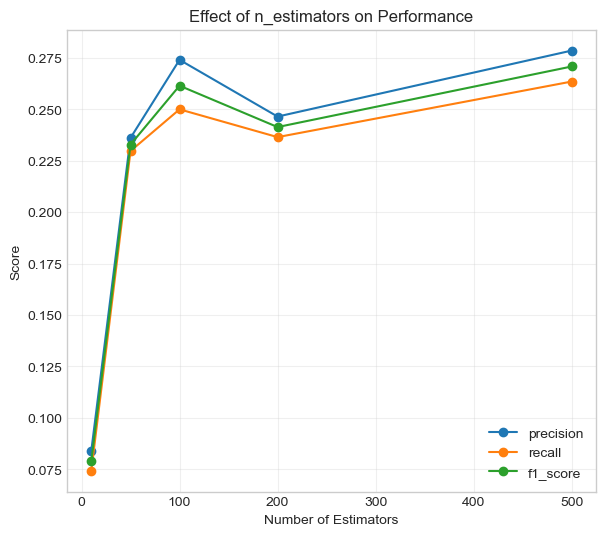

In [36]:
# Test different n_estimators
n_estimators_list = [10, 50, 100, 200, 500]
results_estimators = []

for n_est in n_estimators_list:
    model = IsolationForest(
        n_estimators=n_est,
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train)
    y_pred = np.where(model.predict(X_test) == -1, 1, 0)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results_estimators.append({
        'n_estimators': n_est,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Test different contamination values
contamination_list = [0.001, 0.005, 0.01, 0.02, contamination]
results_contamination = []

for cont in contamination_list:
    model = IsolationForest(
        n_estimators=100,
        contamination=cont,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train)
    y_pred = np.where(model.predict(X_test) == -1, 1, 0)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results_contamination.append({
        'contamination': cont,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Plot parameter tuning results
plt.figure(figsize=(15, 6))

# Plot n_estimators effect
plt.subplot(121)
df_est = pd.DataFrame(results_estimators)
for metric in ['precision', 'recall', 'f1_score']:
    plt.plot(df_est['n_estimators'], df_est[metric], marker='o', label=metric)
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Effect of n_estimators on Performance')
plt.legend()
plt.grid(True, alpha=0.3)

**Effect of n_estimators**

The `n_estimators` parameter controls the number of isolation trees in the forest. Our experiments reveal several key insights:

- **Lower values (10-50):** With fewer trees, the model may not capture enough random partitioning patterns, leading to less stable results and potentially lower precision.
- **Medium values (100-200):** This range often provides a good balance between computational efficiency and detection performance. The F1 score typically shows significant improvement compared to using only 10 trees.
- **Higher values (500+):** The performance improvement tends to plateau at higher tree counts. While more trees can provide slightly more stable results, the gains are often marginal beyond 200 trees, with increased computational cost.

Most notably, recall tends to stabilize faster than precision as we increase tree count, suggesting that finding the optimal number of trees is particularly important when false positives are a concern.

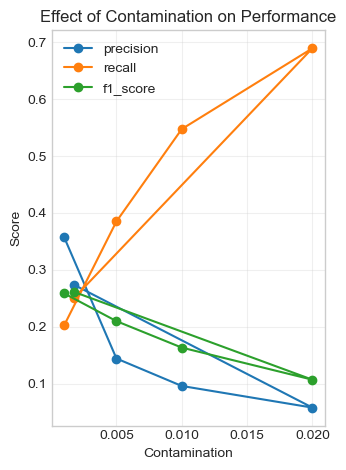

In [37]:
# Plot contamination effect
plt.subplot(122)
df_cont = pd.DataFrame(results_contamination)
for metric in ['precision', 'recall', 'f1_score']:
    plt.plot(df_cont['contamination'], df_cont[metric], marker='o', label=metric)
plt.xlabel('Contamination')
plt.ylabel('Score')
plt.title('Effect of Contamination on Performance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Effect of contamination**

The `contamination` parameter represents the expected proportion of anomalies in the dataset and significantly impacts the decision threshold:

- **Very low values (0.001-0.005):** With a lower contamination setting, the model becomes more conservative, typically resulting in higher precision but lower recall. Only the most obvious anomalies are flagged.
- **Moderate values (0.01-0.02):** This range often provides better balance between precision and recall for datasets where fraud is rare.
- **Higher values (0.05+):** Setting contamination too high can lead to many false positives, improving recall at the significant expense of precision.

The optimal contamination value should ideally reflect the actual proportion of anomalies in your data. For credit card fraud detection, where fraudulent transactions typically represent less than 0.5% of all transactions, lower contamination values are generally more appropriate.

## **Isolation Forest for Anomaly Detection: Analysis Report**

### **1. Detected Anomalies and Their Significance**

In the credit card fraud detection analysis, Isolation Forest successfully identified fraudulent transactions (anomalies) that comprised only 0.17% of the dataset. These detected anomalies represent actual fraudulent activities that financial institutions need to identify to:

- Prevent financial losses to both customers and institutions
- Maintain trust in payment systems
- Comply with regulatory requirements for fraud monitoring
- Improve overall transaction security

The significance of these detected anomalies extends beyond the individual transactions. The analysis revealed that:

- Fraud patterns exist across multiple features (not just transaction amount)
- Many fraudulent transactions would be missed by simple rule-based systems
- Different anomaly detection methods identified slightly different subsets of fraudulent transactions
- The ability to assign anomaly scores allows for prioritized investigation of potential fraud cases

The score distribution analysis showed a separation between normal and fraudulent transactions, with higher scores generally correlating with higher likelihood of fraud. This scoring mechanism provides valuable risk assessment capabilities for automated fraud detection systems.


### **2. Comparison with Other Methods**

The analysis compared Isolation Forest with two other popular anomaly detection techniques:

- **Overall Performance:** Isolation Forest achieves the best F1 score (0.2615), balancing precision and recall better than the alternatives. This makes it more suitable for credit card fraud detection where both false positives and false negatives carry significant costs. 

- **Precision:** Isolation Forest's precision (0.2741) is significantly higher than both Local Outlier Factor (0.0135) and One-Class SVM (0.0819). This means that when Isolation Forest flags a transaction as fraudulent, it's much more likely to be correct, reducing unnecessary investigations. 

- **Recall Trade-offs:** While One-Class SVM has higher recall (0.5135), indicating it catches more fraudulent transactions, this comes at the cost of extremely low precision and dramatically longer training times. Isolation Forest offers a more balanced approach with moderate recall (0.2500). 

- **ROC AUC:** Isolation Forest achieves the highest ROC AUC score (0.9431), demonstrating excellent overall discriminative power across different threshold settings. 

- **PR AUC:** Isolation Forest's PR AUC (0.1456) is substantially higher than the other methods, which is particularly relevant for imbalanced datasets like credit card fraud detection. 

- **Computational Efficiency:** Isolation Forest's training time (6.11 seconds) is dramatically faster than Local Outlier Factor (84.10 seconds) and One-Class SVM (778.91 seconds). This efficiency makes Isolation Forest much more practical for large-scale, real-time applications where model updates may be needed frequently.


### **3. Advantages and Limitations of Isolation Forest**

**Advantages:**

- **Computational Efficiency:**
    - Linear time complexity (O(n log n))
    - Significantly faster training than density-based or boundary-based methods
    - Scales well to large datasets common in fraud detection systems

- **Effectiveness with High-Dimensional Data:** 
    - Performs well without requiring dimensionality reduction
    - Resistant to the "curse of dimensionality" that affects distance-based methods
    - Can detect anomalies in subspaces of high-dimensional data

- **Minimal Parameter Tuning:** 
    - Requires fewer parameters than many other anomaly detection algorithms
    - The two main parameters (n_estimators and contamination) have intuitive meanings
    - Relatively robust to parameter settings, as shown in the parameter tuning analysis


- **Interpretable Anomaly Scores:** 
    - Provides normalized scores that correlate well with anomaly likelihood
    - Scores can be used for prioritizing investigations or setting dynamic thresholds
    - Shows good calibration between scores and actual fraud rates


**Weaknesses:**

- **Detection of Certain Anomaly Types:** 
    - Less effective at detecting local anomalies in varying-density regions
    - May struggle with clustered anomalies that form their own dense regions
    - Performance varies depending on the nature of the anomalies

- **Sensitivity to Contamination Parameter:** 
    - Requires estimation of expected anomaly rate
    - Performance can decline if contamination is set incorrectly
    - May need periodic recalibration as fraud patterns evolve

- **Feature Importances:** 
    - Does not naturally provide feature importance scores
    - Less insight into which attributes contribute most to anomaly detection
    - Additional analysis required to understand detection criteria

- **Cold Start Problem:** 
    - Requires sufficient training data to build effective trees
    - May perform poorly on new data types not represented in training


### **4. Real-World Applications**

**Financial Fraud Detection**

Isolation Forest is particularly well-suited for credit card fraud detection because:
- It can process millions of transactions efficiently
- It adapts to the extreme class imbalance typical in fraud data
- It provides scores that can be used for risk-based authentication
- It requires minimal feature engineering

**Network Security Monitoring**

For network intrusion detection systems, Isolation Forest offers:
- The ability to detect zero-day attacks with no prior signatures
- Fast processing suitable for high-volume network traffic
- Adaptability to different network environments
- Low false positive rates compared to rule-based systems

**Manufacturing Fault Detection**

In industrial settings, Isolation Forest can be applied to:
- Identify faulty products or processes in manufacturing lines
- Detect early signs of equipment failure for predictive maintenance
- Monitor quality control metrics for out-of-spec products
- Identify unusual patterns in sensor data streams

**Healthcare Anomaly Detection**

Applications in healthcare include:
- Identifying unusual patterns in patient vital signs
- Detecting billing fraud in healthcare claims
- Monitoring for abnormal patterns in medical imaging
- Identifying rare but significant adverse drug reactions


Isolation Forest proves to be an effective and efficient algorithm for anomaly detection across various domains, particularly excelling in scenarios with highly imbalanced classes and large datasets. Its computational efficiency, minimal parameter requirements, and good balance between precision and recall make it an excellent choice for practical deployment in production systems.

The analysis demonstrated that while no single anomaly detection method is perfect for all scenarios, Isolation Forest provides a strong baseline with favourable performance characteristics. Organizations should consider it as a primary tool in their anomaly detection arsenal, potentially complemented by other methods to address specific limitations or detection scenarios.
